# Training an MNIST model with PyTorch

In [26]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

### Download training data

In [112]:
use_fashion_mnist = False
if use_fashion_mnist:
    training_data = datasets.FashionMNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )

    test_data = datasets.FashionMNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor(),
    )
else:
    training_data = datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor(),
    )

    test_data = datasets.MNIST(
        root="data",
        train=False,
        download=True,
        transform=ToTensor(),
    )

batch_size = 64


train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

100.0%
100.0%
100.0%
100.0%

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### Visualize the data

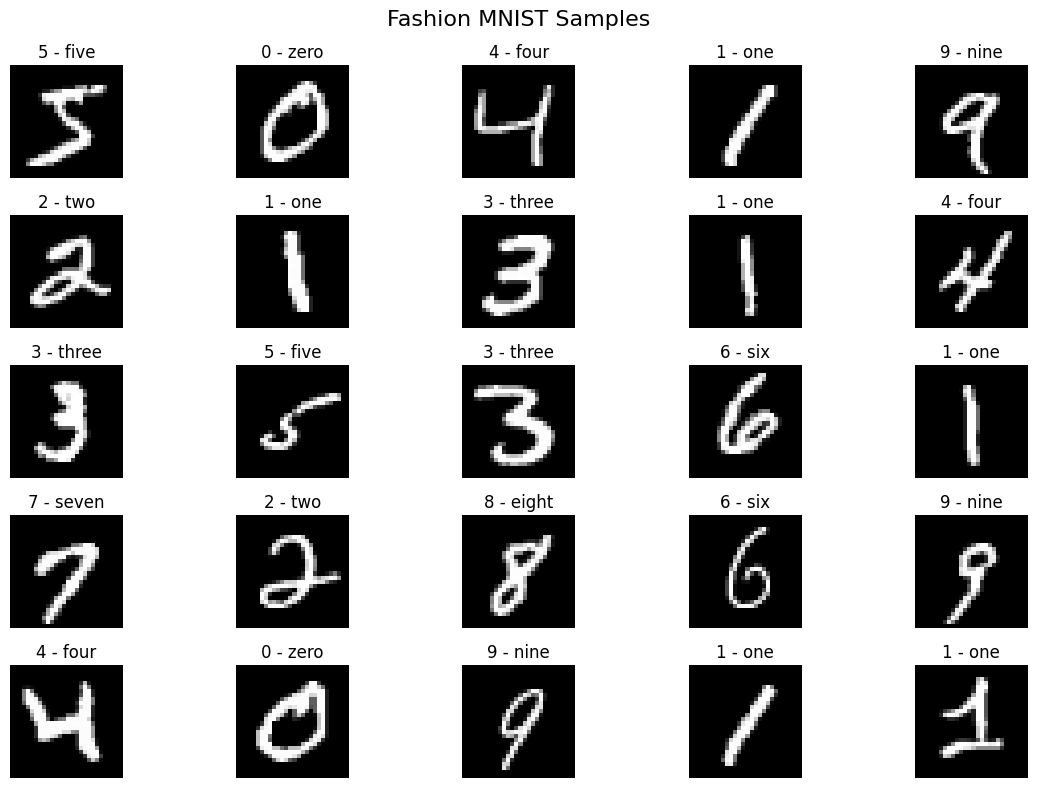

In [ ]:
rows = 5
cols = 5
samples_to_visualize = rows * cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
fig.suptitle('MNIST Samples', fontsize=16)

for i in range(samples_to_visualize):
    row = i // cols
    col = i % cols
    
    image, label = training_data[i]
    class_name = training_data.classes[label]
    
    axes[row, col].imshow(image.squeeze(), cmap="gray")
    axes[row, col].axis("off")
    axes[row, col].set_title(class_name, fontsize=12)

plt.tight_layout()
plt.show()

### Accelaration available?

In [114]:
device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


### Define the model

In [115]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)

### Optimizer and loss function

In [116]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

### Training

In [117]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg test loss: {test_loss:>8f} \n"
    )

In [129]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 1.514213  [   64/60000]
loss: 1.427600  [ 6464/60000]
loss: 1.549606  [12864/60000]
loss: 1.328958  [19264/60000]
loss: 1.345989  [25664/60000]
loss: 1.323739  [32064/60000]
loss: 1.264530  [38464/60000]
loss: 1.410564  [44864/60000]
loss: 1.246007  [51264/60000]
loss: 1.222486  [57664/60000]
Test Error: 
 Accuracy: 77.5%, Avg test loss: 1.188797 

Epoch 2
-------------------------------
loss: 1.231865  [   64/60000]
loss: 1.120194  [ 6464/60000]
loss: 1.243413  [12864/60000]
loss: 1.059966  [19264/60000]
loss: 1.067289  [25664/60000]
loss: 1.046411  [32064/60000]
loss: 0.992592  [38464/60000]
loss: 1.158221  [44864/60000]
loss: 1.020963  [51264/60000]
loss: 0.989977  [57664/60000]
Test Error: 
 Accuracy: 80.2%, Avg test loss: 0.960440 

Epoch 3
-------------------------------
loss: 1.023310  [   64/60000]
loss: 0.898990  [ 6464/60000]
loss: 1.009063  [12864/60000]
loss: 0.871047  [19264/60000]
loss: 0.874777  [25664/60000]
loss: 0.853569  

### Save model

In [35]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


### Load model

In [36]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

### Inference

In [40]:
test_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

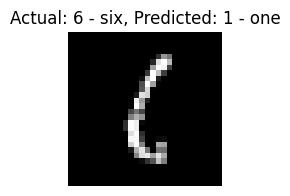

Actual: "6 - six", Predicted: "1 - one"


In [151]:
import random


classes = test_data.classes

def visualize_sample(image, actual_label, predicted_label):
    plt.figure(figsize=(2, 2))

    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()


model.eval()

# sample a random index
random_index = random.randint(0, len(test_data))
x, y = test_data[random_index][0], test_data[random_index][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    visualize_sample(x.cpu(), actual, predicted)
    print(f'Actual: "{actual}", Predicted: "{predicted}"')